# Object Detection - Part 4 Multiple Objects
by John Robinson 02/14/2023 [Follow @johnrobinsn on Twitter](https://twitter.com/johnrobinsn)

![jpeg](https://www.storminthecastle.com/img/04_multiple_objects_files/robot_a_256.jpeg)

[<img src="https://www.storminthecastle.com/img/github.svg">](https://github.com/johnrobinsn/ObjectDetectionNotebooks/blob/main/nbs/04_multiple_objects.ipynb) [<img src="https://www.storminthecastle.com/img/colab.svg">](https://colab.research.google.com/github/johnrobinsn/ObjectDetectionNotebooks/blob/main/nbs/04_multiple_objects.ipynb)

**Part 4** of an article series on building an intuition for how single-pass oject detectors such as YOLO and SSD work.  

[Go Back to Part 1.](https://www.storminthecastle.com/posts/01_classification/)  

Object detection considers the problem of building a model that can take an image and detect multiple objects within that image; predicting not only the object classes but also the bounding boxes of those objects within the image.  Single-pass detectors such as YOLO and SSD are able to perform this object detection task in a single forward inference pass of the model. If what I'm describing is not clear, here is a fun video of [YOLO in action](https://www.youtube.com/watch?v=MPU2HistivI).

In the previous article, we built and trained a model that could locate and classify the largest object within an image..

In this article, I'll start to generalize the model to be able to detect multiple objects within an image.  I have to warn you that the complexity of the model and the code to handle multiple bounding boxes does increase significantly.  We'll be adding in a lot of new concepts and code.  I'll try my best to explain things as we go along and will try to include some other useful references.  

I am going to pull a bit of a switcheroo...  I've been using the FastAI library very heavily in past articles (we'll still use some parts of it...), but in order to get the model to perform well I need to perform some significant image augmentation in the training pipeline.  I love FastAI (it's still my first choice when trying to get something up and running quickly).  But getting that sort of control with FastAI is not as easy as I would like.  This is also a thinly veiled excuse to try out [Jeremy Howard's](https://twitter.com/jeremyphoward) new "experimental" machine learning framework called [MiniAI](https://github.com/fastai/course22p2). I'll be using MiniAI for the rest of the articles in this series.  I'll try to keep the code as similar as possible to the earlier articles so that you can easily follow along.

We can get started by installing MiniAI, FastAI and an image augmentation library called imgaug.

In [1]:
def install_dependencies():
    !pip install -Uqq fastai
    !pip install -Uqq git+https://github.com/johnrobinsn/course22p2.git  # installing from my fork to try and keep this notebook working.  Please see upstream for latest!
    !pip install -Uqq git+https://github.com/johnrobinsn/imgaug.git

install_dependencies()

As I mentioned, we're reducing the amount of FastAI we're using down to a small number of functions that you can see in the import line below.  We'll be limiting the use of FastAI to the following things:

* fetching the dataset
* parsing the dataset metadata
* downloading a pretrained resnet34 model for our backbone
* create_body to create the backbone of our model

_Note: We've used all of these functions either directly or indirectly in earlier articles._

In [2]:
from fastai.vision.all import L,to_np,URLs,untar_data,get_annotations,RandomSplitter,imagenet_stats,create_body,resnet34

Import other necessary modules.

In [3]:
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.training import *

import numpy as np

import matplotlib.colors as mcolors
import matplotlib.cm as cmx
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,Dataset,default_collate
import torch.nn.functional as F

from torchvision import transforms as tfms

#import imgaug as ia
from imgaug.augmentables.bbs import BoundingBoxesOnImage
from imgaug import augmenters as iaa 

import sys
IN_COLAB = 'google.colab' in sys.modules

Let's statically define the class labels in our dataset and create some dictionaries to map between class string labels and class indices.

In [4]:
# class labels from our dataset
vocab = ['bg', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

# shortened class labels more suitable for rendering
vocab_display = ['bg', 'plane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'table', 'dog', 'horse', 'motorbike', 'person', 'plant', 'sheep', 'sofa', 'train', 'tv']


cat2id = {v:k for k,v in enumerate(vocab)}
id2cat = {k:v for k,v in enumerate(vocab_display)}

len(vocab)

21

Pull in some of our code from earlier articles.

In [5]:
seed = 6789
torch.manual_seed(seed)
np.random.seed(seed)

SIZE = 224  # size of images we'll use for the model

# display an image in such a way that we can layer on some additional annotations
def show_img(im,figsize=None,ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    #ax.imshow(im)
    show_image(im,ax) # We use this FastAI method to make life a little easier
    ax.set_xticks(np.linspace(0,SIZE,8))
    ax.set_yticks(np.linspace(0,SIZE,8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

# draw an outline around the shape; used to add contrast to the text so we can read it easily
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw,foreground='black'),patheffects.Normal()])

# draw text in the specified location along with an outline so that there is some contrast between the text and the image
def draw_text(ax,xy,txt,sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top',color=color,fontsize=sz,weight='bold')
    if not IN_COLAB: draw_outline(text, 1) # google colab env is not happy with this

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

# generate a list of different colors for rendering our bounding boxes
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def ybb_hw(a): return np.array([a[0],a[1],a[2]-a[0],a[3]-a[1]])
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.2, bg_label=None, show_conf=True,color=None):
    bb = [ybb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_image(im, ax=ax)
    #k=0
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        #k+=1
        clr = color if color is not None else colr_list[i%num_colr]
        if pr is not None and pr < thresh: c = 0
        if((b[2]>1) and (bg_label!=None or c != 0)):
            draw_rect(ax, b, color=clr)
            txt = f'{i+1}: \n'
            if c is not None: txt += (bg_label if c==0 else vocab_display[c]) + '\n'
            if show_conf and pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=clr)
            
def torch_gt(ax,ima,bbox,clas=None,prs=None,thresh=0.4,bg_label=None,show_conf=True,color=None):
    ima = ((ima+ima.min())/(ima.max()-ima.min())).clamp(0,1)
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         clas, to_np(prs) if prs is not None else None, thresh,bg_label,show_conf,color=color)

### Download and Read the Dataset
Download the dataset again and load it's metadata. But instead of creating a derived dataset with just the largest object within an image, we'll be using the full dataset with one or more bounding boxes and classes for each image.

In [6]:
path = untar_data(URLs.PASCAL_2007)
imgs,lbl_bbox = get_annotations(path/'train.json') # fastai gives a convenient way to parse and load the annotations

#(number of images, image name, (bounding boxes, class labels))
len(imgs),imgs[1],lbl_bbox[1]

(2501,
 '000017.jpg',
 ([[184, 61, 279, 199], [89, 77, 403, 336]], ['person', 'horse']))

This sample has an image with two bounding boxes with a class label for each.  The first bounding box is for a person and the second bounding box is for a horse.

Given an image name, we want to easily be able to get the bounding boxes and class labels for that image, so let's create a dictionary for that purpose.

In [7]:
# Create a dictionary of image names to bounding boxes and bounding box labels
img2bbox = dict(zip(imgs,lbl_bbox))

# Use the dictionary to look up a sample from the dataset with multiple bounding boxes
k = L(img2bbox)[1]
k,img2bbox[k]

('000017.jpg',
 ([[184, 61, 279, 199], [89, 77, 403, 336]], ['person', 'horse']))

Let's make a few getter fuctions to make it easier to access the data.

In [8]:
# define an array of getter functions to get the fully qualified path to an image, the bounding boxes, and the bounding box class label
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]

# and lets try it out
k,getters[0](k),getters[1](k),getters[2](k)

('000017.jpg',
 Path('/home/jr/.fastai/data/pascal_2007/train/000017.jpg'),
 [[184, 61, 279, 199], [89, 77, 403, 336]],
 ['person', 'horse'])

#### Padding our Tensors
Since our images can have multiple bounding boxes and class labels but PyTorch can't really deal with variable length tensors, we need to pad these tensors out with zeros, so they're all the same size.  Here we'll calcuate the maximum number of bounding boxes and class labels within our dataset and use that as the padded out size.

In [9]:
max_instances = max([len(getters[2](i)) for i in imgs])
max_instances

37

Here I define a utilty function that will take a list of string class labels, converts them to their integer class indices, and then zero-pads the list out to the max number of object instances (max_instances) calculated above.

In [10]:
def pad_cat2id(l): 
    l = [cat2id[o] for o in l]
    l += ([0]*(max_instances-len(l)))
    return l

# Try it out
print(pad_cat2id(['cat','horse','dog']))

[8, 13, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### Image Normalization
Image normalization is something that FastAI did for us automatically, but we need to do it manually for MiniAI.  A rule of thumb for machine learning models is that we should normalize the model inputs to have a standard deviation of one and a mean of zero in order to avoid floating point numeric problems, so we'll need to do that for our image data.  

One other consideration is that we'll be using a pretrained resnet34 model as our backbone, so we need to use the same normalization values that were used for calculating those pretrained weights.  Otherwise our backbone won't be able to identify features within our images.  The resnet34 pretrained model was trained on the ImageNet dataset.  FastAI defines constant values for the ImageNet statistics, so we'll leverage that to scale and center our images values channel by channel.

In [11]:
# RGB channel means and standard deviations for the ImageNet dataset
xmean,xstd = L(imagenet_stats).map(tensor)
xmean,xstd

(tensor([0.4850, 0.4560, 0.4060]), tensor([0.2290, 0.2240, 0.2250]))

In [12]:
# denormalize the image data based on imagenet stats
def denormalize(x):
    return x*xstd[...,None,None]+xmean[...,None,None]

# scale and center the image data based on imagenet stats
def normalize(x):
    return (x-xmean[:,None,None])/xstd[:,None,None]

Let's try out the normalization functions on a sample image.

_Note: if we try to render the normalized image it looks a bit corrupted (See Below) since the image rendering functions expect values between 0 and 1. So if you see images like this you will need to denormalize them for viewing with human eyes._

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


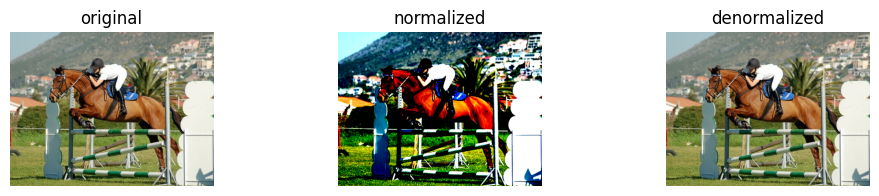

In [13]:
f = imgs[1]
im = Image.open(getters[0](f))
im = tfms.ToTensor()(im)
original, normalized, denormalized = im, normalize(im), denormalize(normalize(im))
show_images([im,normalized,denormalized],titles=['original','normalized','denormalized'],figsize=(12,2))

We can also look at how the image statistics differ between the original image and the normalized image.

In [14]:
print('Original:', original.min(), original.max(), original.mean(), original.std())
print('Normalized:', normalized.min(), normalized.max(), normalized.mean(), normalized.std())

Original: tensor(0.) tensor(1.) tensor(0.5006) tensor(0.2443)
Normalized: tensor(-2.1179) tensor(2.6400) tensor(0.2284) tensor(1.0633)


#### Validation Split
Another thing we'll do manually since we're using MiniAI is split our dataset into a training set and a validation set.  We'll use a random 20% split of the dataset for validation purposes.

_Note: Same split percentage that we've used in earlier articles._

In [15]:
tsplit,vsplit = RandomSplitter()(range(len(imgs)))  # split the data into training and validation sets using fastai's RandomSplitter to create indexes into the imgs array
tsplit,vsplit # random indices into the imgs array (train indices, validation indices)

((#2001) [2107,12,40,795,369,1885,1876,1272,883,1655...],
 (#500) [2403,2046,816,899,1680,2245,2297,719,1495,935...])

In [16]:
tt,vt = L(imgs)[tsplit],L(imgs)[vsplit]  # use the random indices to create random subsets of the imgs array (training set, validation set)
tt,vt # random subsets of the imgs array (training set, validation set)

((#2001) ['008422.jpg','000048.jpg','000173.jpg','003204.jpg','001529.jpg','007490.jpg','007458.jpg','005023.jpg','003524.jpg','006501.jpg'...],
 (#500) ['009584.jpg','008166.jpg','003280.jpg','003588.jpg','006627.jpg','008988.jpg','009208.jpg','002906.jpg','005884.jpg','003704.jpg'...])

### Augmenting both Images and Bounding Boxes

One of the most important regularization techniques within computer vision is to apply image augmentations to images used to train the model.  Image augmentations are where we programmatically and at random apply some image transformation.  These transformations can include rotating the image, scaling the image, cropping parts of the image out, changing brightness and contrast, etc.  Performing these transformations has a lot of positive effects.  One is that we get more labled image data (with increased variation) for "free".  It also prevents our model from overfitting (memorizing) the training set, the goal is for our model to work well with new unseen images.  The problem is once we start dealing with bounding boxes, the coordinates of these bounding boxes are defined in terms of the original image space.  If we apply an augmentation to the image, the bounding boxes will no longer be in the correct location.  We need to apply the same augmentation (in bounding box terms) to the bounding boxes so that they are still in the correct location.  This is a bit tricky to do, but there are a few libraries that can help us out.  One good choice is [imgaug](https://github.com/aleju/imgaug).  

_Note: FastAI has some limited support for bounding boxes but it's difficult to extend and not sufficient for our needs._

Imgaug lets us define a sequence of transformations that we can apply to an image along with it's associated bounding boxes.  Let's start off with a simple transform that we'll apply to our validation dataset which just scales the image and the bounding boxes defined in pixel coordinates.

In [17]:
# Only used for the validation dataset.  Simply scales the image and it's associated bounding boxes to 224x224
vseq = iaa.Sequential([
    iaa.Scale({"height": 224, "width": 224})
])

/home/jr/anaconda3/envs/fastaip2_3/lib/python3.9/site-packages/imgaug/imgaug.py:188: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  warn_deprecated(msg, stacklevel=3)


For our training dataset, we want to apply a more complex set of transformations.  We'll apply a random crop to the image, a random rotation, a random zoom, and a random flip.  We'll also apply a random brightness and contrast change and a few other things (Please refer to the [imgaug docs](https://nbviewer.org/github/aleju/imgaug-doc/blob/master/notebooks/B02%20-%20Augment%20Bounding%20Boxes.ipynb) for more information).

In [18]:
tseq = iaa.Sequential([
    iaa.Scale({"height": 224, "width": 224}),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.20),
    iaa.GammaContrast(1.5),
    iaa.Sometimes(
        0.5,iaa.Sequential([iaa.Affine(translate_percent={"x": (-0.15,0.15),"y": (-0.15,0.15)},rotate=(5,-5), scale=(0.15, 1.5)),
            iaa.CoarseDropout(0.1, per_channel=True)    
            ])
        )
    ])

#### Trying out imgaug
Let's try out our imgaug transformations on a sample image from our dataset. 

<AxesSubplot: >

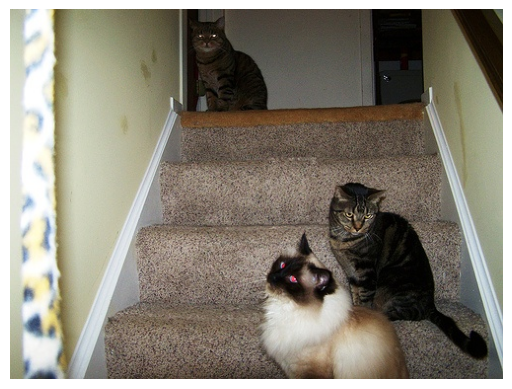

In [19]:
k = vt[0]  # get a file name from the validation set
im = np.array(Image.open(getters[0](k))) # Get the full path for the image, load it and convert it to a numpy array for imgaug
b = getters[1](k) # get the bounding boxes for the image
show_image(im) # show the image

Create an instance of an imgaug BoundingBoxesOnImage with the bounding boxes and draw the original unscaled/unaugmented image along with its bounding boxes.

BoundingBoxesOnImage([BoundingBox(x1=177.0000, y1=3.0000, x2=263.0000, y2=104.0000, label=None), BoundingBox(x1=322.0000, y1=173.0000, x2=487.0000, y2=358.0000, label=None), BoundingBox(x1=255.0000, y1=224.0000, x2=409.0000, y2=375.0000, label=None)], shape=(375, 500, 3))
['cat', 'cat', 'cat']


<AxesSubplot: >

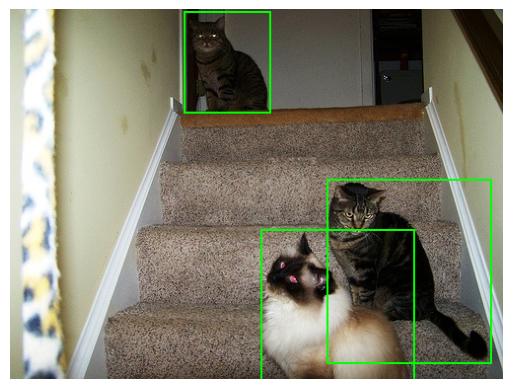

In [20]:
bbs = BoundingBoxesOnImage.from_xyxy_array(b, shape=im.shape)

print(bbs) # print the bounding boxes for this image for context
print(getters[2](k)) # show the class labels for this image for context

show_image(bbs.draw_on_image(im,size=2))

Apply the "validation" augmentation to the image and bounding boxes. 

_Note: Just a scale of both to 224x224_

BoundingBoxesOnImage([BoundingBox(x1=79.2960, y1=1.7920, x2=117.8240, y2=62.1227, label=None), BoundingBox(x1=144.2560, y1=103.3387, x2=218.1760, y2=213.8453, label=None), BoundingBox(x1=114.2400, y1=133.8027, x2=183.2320, y2=224.0000, label=None)], shape=(224, 224, 3))


<AxesSubplot: >

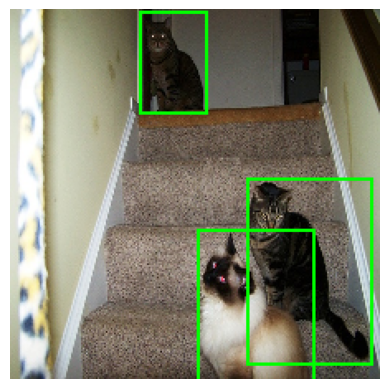

In [21]:
im_aug,bb_aug = vseq(image=im, bounding_boxes=bbs) # vseq is the validation sequence, it only scales the image and bounding boxes

print(bb_aug)

show_image(bb_aug.draw_on_image(im_aug,size=2))

Now we'll run the same image through the training augmentation sequence.  

_Note: This is a random sequence of transformations so you'll get different results each time you run this.  Also don't be surprised by the color tranformation within the images.  It's intentional._

BoundingBoxesOnImage([BoundingBox(x1=106.1760, y1=161.8773, x2=144.7040, y2=222.2080, label=None), BoundingBox(x1=5.8240, y1=10.1547, x2=79.7440, y2=120.6613, label=None), BoundingBox(x1=40.7680, y1=0.0000, x2=109.7600, y2=90.1973, label=None)], shape=(224, 224, 3))


<AxesSubplot: >

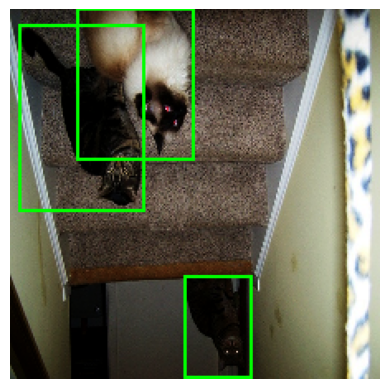

In [22]:
im_aug,bb_aug = tseq(image=im, bounding_boxes=bbs)

print(bb_aug)

show_image(bb_aug.draw_on_image(im_aug,size=2))

### Create the Training and Validation Dataset

Now we'll define a PyTorch dataset subclass that we'll use to provide data to our training loop.  I'll pass in augment=True for our training dataset which will apply the correct imgaug transformations to the image and bounding boxes.  For our validation dataset I'll pass in augment=False which will just scale the image and bounding boxes to the correct size.  If the random image augmentations cause any one of the bounding boxes to be fully outside of the image bounds, we'll just revert back to the original image and bounding boxes and not augment this sample.

In [23]:
class ObjectDS(Dataset):
    def __init__(self,d,augment=False): self.d = d; self.augment = augment
    def __getitem__(self,index):
        i = self.d[index]
        p = getters[0](i)
        im = np.array(Image.open(p))

        bbs = BoundingBoxesOnImage.from_xyxy_array(getters[1](i), shape=im.shape)
        if (self.augment): 
            im_aug,bbs_aug = tseq(image=im, bounding_boxes=bbs)
            bbs_aug = bbs_aug.clip_out_of_image()
            if len(bbs_aug.bounding_boxes) == 0: # at least one bounding box is fully outside of the image boundary
                # bail out of augmentation for this sample
                #print('bailing out of augmentation for this sample')
                im_aug,bbs_aug = vseq(image=im, bounding_boxes=bbs)
        else: im_aug,bbs_aug = vseq(image=im, bounding_boxes=bbs)

        b = bbs_aug.to_xyxy_array()/(SIZE/2)-1  # scale the bounding boxes to be between -1 and 1

        im = normalize(tfms.ToTensor()(im_aug)) # normalize the image data with imagenet stats

        b = torch.cat([tensor(b),torch.zeros(max_instances-len(b),4)]) # pad the number of bounding boxes to max_instances
        c = tensor(pad_cat2id(getters[2](i)))
        return im,b,c  # these are all tensors at this point.
    def __len__(self): return len(self.d)
    
ts = ObjectDS(tt,True)  # training dataset with augmentation applied
vs = ObjectDS(vt,False) # validation dataset with no augmentation applied (just scaling to 224x224)

len(ts),len(vs)

(2001, 500)

Let's look at a normalized, augmented image from our dataset.  matplotlib will complain about the image being out of bounds, but that's expected for a normalized image.  I just want you to see how a normalized image will look when matplotlib renders it. If you reload this cell repeatedly you will get randomly augmented variants of the same image.

_Note: For reference the denormalized (but still augmented) image is shown below._

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot: >

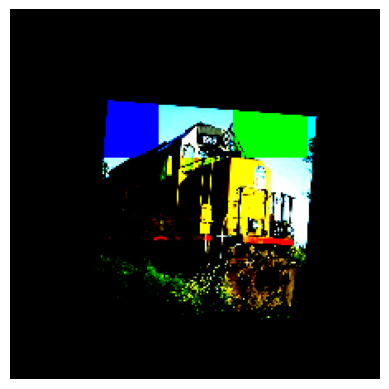

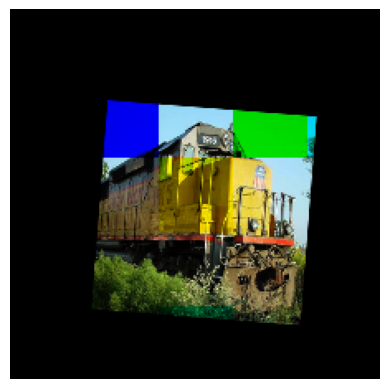

In [24]:
sample = ts[10][0]
show_image(sample)
show_image(denormalize(sample)) # you'll likely see some "colored blocks" in the normalizd image from the CoarseDropout augmentation

Here we create the dataloaders which will collate our training data into batches and optionally shuffle the batches during training.

In [25]:
bs = 64
tl = DataLoader(ts,batch_size=bs,shuffle=True,drop_last=True)
vl = DataLoader(vs,batch_size=bs,shuffle=False,drop_last=True)

# Since we're randomizing the training data in our dataset I use a simple wrapper that does no caching.
class SimpleDataLoaders():
    def __init__(self): self.train = tl;self.valid=vl

dls=SimpleDataLoaders()

# bs=64
# dls = DataLoaders(*get_dls(ts,vs,bs=bs,num_workers=8,drop_last=True))

### The Model

As in earlier articles, we'll use a resnet34 backbone with a custom head.  We could try to create a custom head made up of linear layers which would work, but can we do something better?  Linear layers will not be able to take advantage of the spatial structure of the activations in our backbone.  

Let's take a closer look at the resnet34 backbone by first cutting off it's existing head and running a batch of images (batch size 64) through it and examining the shape of it's output.


In [26]:
body = create_body(resnet34(True))

x,*_ = next(iter(tl)); x.shape # get a batch of images from the training dataset

body(x).shape  # pass the batch of images through the body of the resnet34 model and print the shape of the output

/home/jr/anaconda3/envs/fastaip2_3/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/jr/anaconda3/envs/fastaip2_3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([64, 512, 7, 7])

The output tensor of the backbone is 7x7 with 512 channels.  So what if instead of using a linear layer, we instead use a stride 2 convolutional layer, we should be able to get a 4x4xC output tensor.  This will give us the ability to have 16 object detectors (4x4) which can take advantage of the spatial structure and receptive fields of our backbone.  

![Stride 2 Convolution](https://www.storminthecastle.com/img/04_multiple_objects_files/ssd_head_bg.png)

Given this let's define the head and create a model that combines the backbone and the head.

In [27]:
class StdConv(nn.Module):
    def __init__(self,nin,nout,stride=2,drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin,nout,3,stride=stride,padding=1) 
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

In [77]:
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

# For each one of the object detectors we will need to have 21 activations for our class labels
# and 4 activations for the bounding box coordinates.
class OutConv(nn.Module):
    def __init__(self,k,nin,bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin,(len(vocab))*k,3,padding=1)
        self.oconv2 = nn.Conv2d(nin,4*k,3,padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x),self.k),
                flatten_conv(self.oconv2(x),self.k)]

The head for the model.

In [29]:
drop=0.0

class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)  # stride 1 convolution to add more computation
        self.sconv2 = StdConv(256,256)            # stride 2 convolution to reduce the size of the feature map to 4x4
        self.out = OutConv(k, 256, bias)          # output convolution to get the class labels and bounding box coordinates
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        # print(x.shape)  # will print torch.Size([64, 256, 4, 4]) for batch size 64
        return self.out(x)

Let's create an instance of the full model and look at the output shape of the model.

In [30]:
# Assemble our model
k=1
head_reg4 = SSD_Head(k, -3.) # create an instance of custom head as described above
body = create_body(resnet34(True))  # create a resnet34 model with pretrained weights (downloaded) using fastai's create_body function
model = nn.Sequential(body,head_reg4) # combine the body and the head into a single model

Let's run our batch (batch size 64) through the entire model and look at the output shape.

In [31]:
pred_clas,pred_bbox = model(x)
pred_clas.shape,pred_bbox.shape

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

The head for the model will provide us with enough activations for 16 object detectors.  16x21 activations for our class labels and 16x4 activations for our bounding box coordinates.

### Anchor Boxes and the Matching Problem
In order to be able to detect different objects at different locations, we want to be able to give each of our 16 object detectors a "frame of reference" to work with.  We do this by defining 16 cooresponding anchor boxes.  These anchor boxes are fixed in position and size and are defined by a center position (x,y) along with a width and a height.  Each anchor box will define a "frame of reference" for its set of activations. 

The activations driven by the loss function will learn to predict an associated bounding box relative to its anchor box.  The activations will be able to offset the center of the bounding box relative to the anchor box by up to 50% of the anchor boxes width and height.  Similarly the activations will also be able to increase or decrease the size of the bounding box by +/- 50% of the anchor boxes size.  

In order to do this we need to have an algorithm for matching the ground truth bounding boxes from our training set to the anchor boxes.  This is called the matching problem. The goal is to find the best match between each anchor box and the ground truth bounding boxes, so that the model can learn to predict the correct location of the objects in the test images.

There are several ways to approach the matching problem, in this article we'll focus on the IoU (Intersection over Union) method.  The Intersection over Union (IoU) algorithm is a commonly used evaluation metric in object detection, segmentation, and tracking tasks. It is used to measure the overlap between two boxes, and provides a scalar value that indicates the similarity between the two boxes.

The IoU between two bounding boxes, A and B, is defined as the ratio of the area of their intersection to the area of their union:

IoU(A, B) = area(A ∩ B) / area(A ∪ B)

where area(X) refers to the area of bounding box X.

The IoU value ranges from 0 to 1, with 1 indicating a perfect match between the two bounding boxes, and 0 indicating no overlap. 

*Note: The IoU value is also symmetric, meaning that IoU(A, B) = IoU(B, A).*

### Define the anchor boxes
We programmatically create the coordinates for our sixteen anchor boxes.

In [32]:
# Function to convert BB format: (centers and dims) -> corners
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset,1-anc_offset,anc_grid),anc_grid)
anc_y = np.tile(np.linspace(anc_offset,1-anc_offset,anc_grid),anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y],axis=1),(k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])

anchors = tensor(np.concatenate([anc_ctrs,anc_sizes],axis=1),requires_grad=False).cuda()
grid_sizes = tensor(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1).cuda()

anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:]).cuda()

We can get a sense of what the anchor boxes look like by plotting them on top of a sample image.

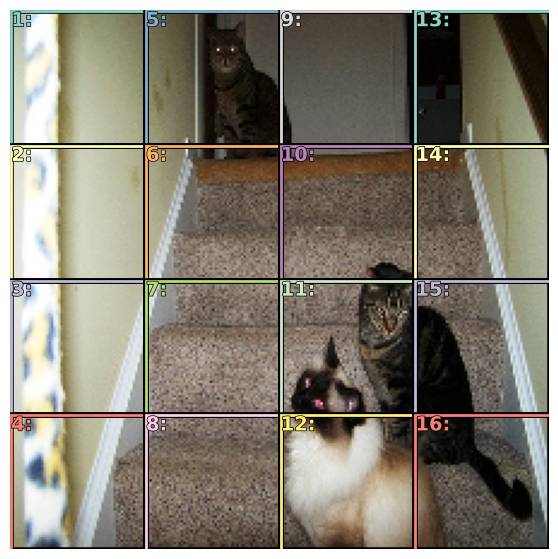

In [33]:
x = denormalize(vs[0][0])
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, x, anchor_cnr, bg_label='')

### Activations and Bounding Box Offsets and Scale

As described above the activations for the bounding boxes will no longer be used to directly predict the coordinates of the bounding box (as we did in earlier articles).  Instead the activations are used to predict the offset and scale of the bounding box relative to its anchor box.  The offset and scale of the bounding box will be predicted by the activations as a percentage of the anchor boxes width and height.  The activations will be able to offset the center of the bounding box relative to the anchor box by up to 50% of the anchor boxes width and height.  Similarly the activations will also be able to scale the size of the bounding box by +/- 50% of the anchor boxes size.

The mapping from the activations to the bounding box offset and scale is defined by the actn_to_bb function shown below.

In [34]:
# bounding boxes are defined relative to a bounding box
# two of the activations provide the offsets of the bounding box from the anchor boxes and
# two of the activations provide the scaling factors of the bounding box from the anchor boxes
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    bbox_centers = anchors[:,:2]+(actn_bbs[:,:2]/2*grid_sizes)
    bbox_hw = anchors[:,2:]+(actn_bbs[:,2:]/2)*anchors[:,2:]
    return hw2corners(bbox_centers,bbox_hw)


To help explain further, here we simulate a few activations (4 floating point numbers ranging from -1 to 1, (offsetX,offsetY,scaleWidth,scaleHeight)) and plot the resulting bounding box offset and scale.

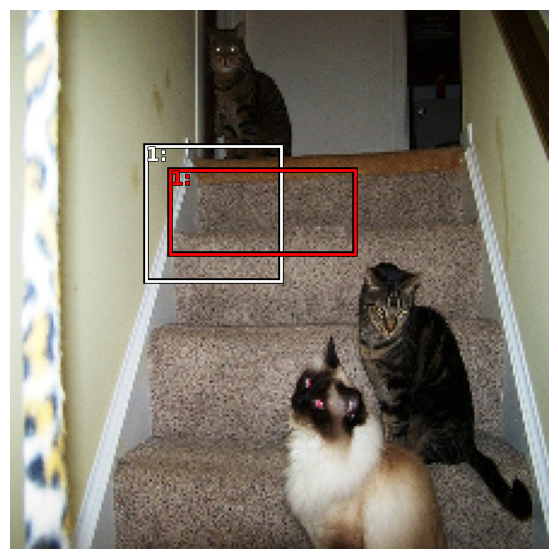

In [35]:
x = denormalize(vs[0][0])
fig, ax = plt.subplots(figsize=(7,7))

one_anchor = anchors[5:6]  # select the 6th anchor box to experiment with

# a few sample fake activations (you can play around with these values)
#fake_actn = tensor([[0,0,0,0]]) # bounding box will overlap exactly with the anchor box (occluding the anchor box)
#fake_actn = tensor([[0,0,1,1]]) # bounding box center will be at the center of the anchor box and will be 50% bigger than the anchor box
#fake_actn = tensor([[0,0,-1,-1]]) # bounding box center will be at the center of the anchor box and will be 50% smaller than the anchor box
#fake_actn = tensor([[-1,-1,0,0]]) # bounding box will be offset to the top left of the anchor box but be the same size as the anchor box
fake_actn = tensor([[1,0,1,-1]]) # bounding box will be offset to the far right of the anchor box and will be 50% wider and 50% shorter than the anchor box

# map the activation values to bounding boxes coordinates
bounding_boxes = actn_to_bb(fake_actn.cuda(), one_anchor)

torch_gt(ax,x,anchor_cnr[5:6],bg_label='bbox',color='white') # show the anchor box in white
torch_gt(ax,x,bounding_boxes,bg_label='anchor',color='red')  # show the bounding box in red

### The Loss Function


As we've discussed earlier, we will have a compound loss function because we have two different types of activations.  Our bounding box related activations will be trained using a regressive L1Loss.  But earlier for class label activations we used CrossEntropyLoss. CrossEntropyLoss is no longer the best choice, because we are introducing the concept of 'bg' (background) which we'll use when there is nothing detected.  We have to treat 'nothing' a little special since it is quite difficult for a classification model to learn to detect nothing.  Rather it is better to have it detect all of the things that are valid objects and use a low probability score on all of the valid objects to determine that there is 'nothing(bg)'.  So for this reason, we'll use a classification loss function that is suited for multi-label classification.  

The concept of 'bg' introduces another problem,  It is much more likely for one of our object detectors to not detect any of our object classes and be classified as 'bg', resulting in a class imbalance between bg vs not-bg (bg is much more likely).  Focal loss is a loss function used in object detection algorithms to address the problem of class imbalance, where the number of negative samples (background) is much larger than the number of positive samples (objects). In such cases, the model can easily become biased towards the negative samples, leading to poor performance in detecting the objects of interest.

The focal loss function was introduced in the [Focal Loss for Dense Object Detection paper](https://arxiv.org/abs/1708.02002), and is designed to down-weight the loss for well-classified samples and focus more on hard, misclassified samples.

In [36]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()].cuda()
    
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def area(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

# calculate the IoU between two sets of bounding boxes
def iou(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = area(box_a).unsqueeze(1) + area(box_b).unsqueeze(0) - inter
    return inter / union

In [37]:
# BCE_Loss is a good choice for multi label classification
class BCE_Loss(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self,pred,targ):
        t = one_hot_embedding(targ.squeeze(),self.num_classes)
        t = t[:,1:] # skip over the bg label at index zero
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x,t,w.detach(),reduction='sum')/self.num_classes
    
    def get_weight(self,x,t): return None

In [38]:
# Subclass BCE_Loss to create a Focal Loss
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

In [39]:
loss_f = FocalLoss(len(vocab))

In [40]:
# remove any bb with width or height of 0
def filter_empty_boxes(bbox,clas):
    bbox = bbox.view(-1,4)
    clas = clas.view(-1,1)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]  
    return bbox[bb_keep],clas[bb_keep]

# Choose the anchor boxes that have the largest overlap with the ground truth bounding boxes
def map_to_ground_truth(overlaps):
    _prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99 # all anchors that match a gt have an overlap of 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

In [41]:
# match target bounding boxes and target classes to anchor boxes
def match(anchor_cnr,targ_boxes,targ_clses,thresh=0.4):
    targ_boxes,targ_clses = filter_empty_boxes(targ_boxes,targ_clses)
    overlaps = iou(targ_boxes, anchor_cnr)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps) # amount of overlap between predicted boxes and targ_boxes and the index of the targ box with the highest overlap for every predicted box

    pos = gt_overlap >= thresh   # boolean mask of which anchor boxes have an overlap with a gt bounding box greater than the threshold
    pos_idx = torch.nonzero(pos)[:,0] # indexes for anchor boxes that are true in boolean mask
    
    gt_bbox = targ_boxes[gt_idx] # number of gt_idx same as number of anchors; so for each anchor box provide the coordinates of the best matching gt box

    gt_clas = targ_clses[gt_idx] # for each predicted box, the target class label
    gt_clas[~pos] = 0 # class label where overlap is below threshold is set to zero (bg)
    
    return pos_idx,gt_bbox,gt_clas  # (anchor box indexes that are relevant, gt bounding boxes for every anchor box, gt class labels for every anchor box)

In [42]:
# defines a joint loss function using a combination of the localization loss and the classification loss
def ssd_1_loss(pred_boxes,pred_clses,targ_boxes,targ_clses):
    targ_boxes = (targ_boxes+1)/2

    # match target boxes to anchor boxes
    pos_idx,gt_bbox,gt_clas = match(anchor_cnr,targ_boxes,targ_clses)

    # map activations to bounding boxes
    a_ic = actn_to_bb(pred_boxes, anchors)

    loc_loss = (a_ic[pos_idx] - gt_bbox[pos_idx]).abs().mean() # l1loss
    cls_loss  = loss_f(pred_clses, gt_clas)
    
    return loc_loss, cls_loss

In [43]:
def ssd_loss(batch_preds, batch_targ_boxes, batch_targ_clses):
    lcs, lls = 0., 0.
    W = 1.
    # iterate through the batch and sum up the losses
    for pred_clses, pred_boxes, targ_boxes, targ_clses in zip(*batch_preds, batch_targ_boxes, batch_targ_clses):
        loc_loss, clas_loss = ssd_1_loss(pred_boxes,pred_clses,targ_boxes,targ_clses)
        lls += loc_loss
        lcs += clas_loss
    #print(f'loc: {lls.item()}, clas: {lcs.item()}')
    return lls + lcs*W

Let's take look at example of how our loss function will match up ground truth bounding boxes against the anchor boxes.

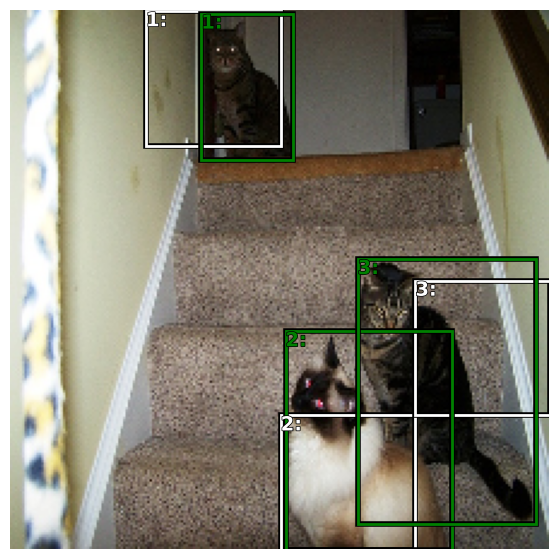

In [44]:
x,targ_bbox,targ_clas = next(iter(vl)) # use an iterator to get the first batch from the validation set
x,targ_bbox,targ_clas = x[0],targ_bbox[0],targ_clas[0]  # just look at one image from the batch

fig, ax = plt.subplots(figsize=(7,7))

targ_bbox = (targ_bbox+1)/2 # normalize the bounding boxes

# match target boxes to anchor boxes
pos_idx,gt_bbox,gt_clas = match(anchor_cnr,targ_bbox.cuda(),targ_clas.cuda())

xn = denormalize(x) # denormalize the image
torch_gt(ax,xn,anchor_cnr[pos_idx],bg_label='bbox',color='white') # show the anchor boxes that match the best in white
torch_gt(ax,xn,gt_bbox[pos_idx],bg_label='anchor',color='green')  # show the ground truth bounding boxes in green

## Training the Model

Train our model using the MiniAI training loop.  Since we are using pretrained weights in the model body, we'll need to freeze the weights of the model body and only train the weights of the head for some number of epochs.  Since this the task of object detection is quite different and we have a fairly complicated head, we'll train the head for a fair number of epochs before unfreezing the model body and training the entire model for additional epochs.

_Note: The number of epochs to train the head and the number of epochs to train the entire model are hyperparameters that you can tune._

In [45]:
# Utility function to "freeze" or "unfreeze" PyTorch model layers
# iterate thru the layer parameters and set requires_grad to False to freeze; to True to unfreeze
# this is useful for fine-tuning a model, where you want to freeze the initial layers and only train the last layers
# requres_grad is a PyTorch attribute that determines whether the model will update the weights for that layer during training

def freeze(m,f):
    for p in m.parameters():
        p.requires_grad = not f # try p.requires_grad_(not f) instead

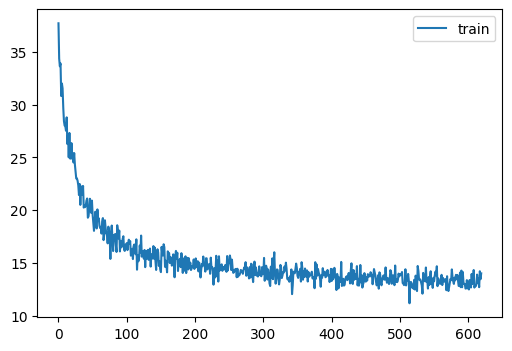

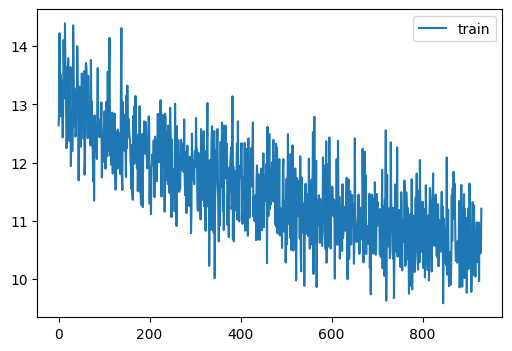

In [46]:
# Assemble our model
k=1
head_reg4 = SSD_Head(k, -3.) # create an instance of custom head as described above
body = create_body(resnet34(True))  # create a resnet34 model with pretrained weights (downloaded) using fastai's create_body function
model = nn.Sequential(body,head_reg4).cuda() # combine the body and the head into a single model

def train():
    for m in head_reg4.modules():
        if isinstance(m,(nn.Conv1d,nn.Conv2d,nn.Conv3d)): nn.init.kaiming_normal_(m.weight)

    cbs = [DeviceCB(),ProgressCB(plot=True),TrainCB(),MetricsCB()]
    learn = Learner(model,dls,ssd_loss,lr=1e-4,cbs=cbs,opt_func=optim.AdamW)
    
    freeze(body,True)
    learn.fit(20)
    freeze(body,False)
    learn.fit(30)

# if you have a saved model, load it here
if False:
    model.load_state_dict(torch.load('ssd_resnet34_small.pth'))
else:
    train()

In [58]:
# save the model if you want to load it in the future
#torch.save(model.state_dict(), 'ssd_resnet34_small.pth')

### Visualize the predictions
Now that we've trained our model to detect bounding boxes and labels, let's see how well it does. Let's run a batch of data through our model and see what the output looks like. We'll take a look at first few images from our batch. In the first column below we show the original image overlayed with the anchor boxes and predicted class labels.  In the second column, we hide the anchor boxes that predicted 'bg'.  In the third column, we are showing the predicted bounding boxes (offset and scaled from the fixed anchor boxes).

In [59]:
# A utility function to visualize the predictions on a subset of the batch
def show_preds(x,pred_clas,pred_bbox,thresh=0.11):
    fig, axes = plt.subplots(6, 3, figsize=(18, 36))
    for idx,ax in enumerate(axes):
        ima = denormalize(x[idx]).clamp(0,1) # make our image look pretty again
        a_ic = actn_to_bb(pred_bbox[idx], anchors)
        torch_gt(ax[0],ima,anchor_cnr,pred_clas[idx].max(dim=1)[1],pred_clas[idx].max(1)[0].sigmoid(),thresh=0.0001,bg_label='bg')
        #torch_gt(ax[0],ima,(targ_bbox[idx]+1)/2,targ_clas[idx],bg_label='bg',color='green')
        torch_gt(ax[1],ima,anchor_cnr,pred_clas[idx].max(dim=1)[1],pred_clas[idx].max(1)[0].sigmoid(), thresh=thresh)
        torch_gt(ax[2],ima,a_ic,pred_clas[idx].max(dim=1)[1],pred_clas[idx].max(1)[0].sigmoid(), thresh=thresh)
    plt.subplots_adjust(wspace=0.15, hspace=0.15)
    axes[0,0].set_title('Anchor Boxes')
    axes[0,1].set_title('Anchor Boxes (BG Removed)')
    axes[0,2].set_title('Predicted Bounding Boxes')

In [66]:
# Get a batch from the validation set; 3-tuple of (image, bbox, clas)
xb,targ_bboxb,targ_clasb = next(iter(vl)) # use an iterator to get the first batch from the validation set

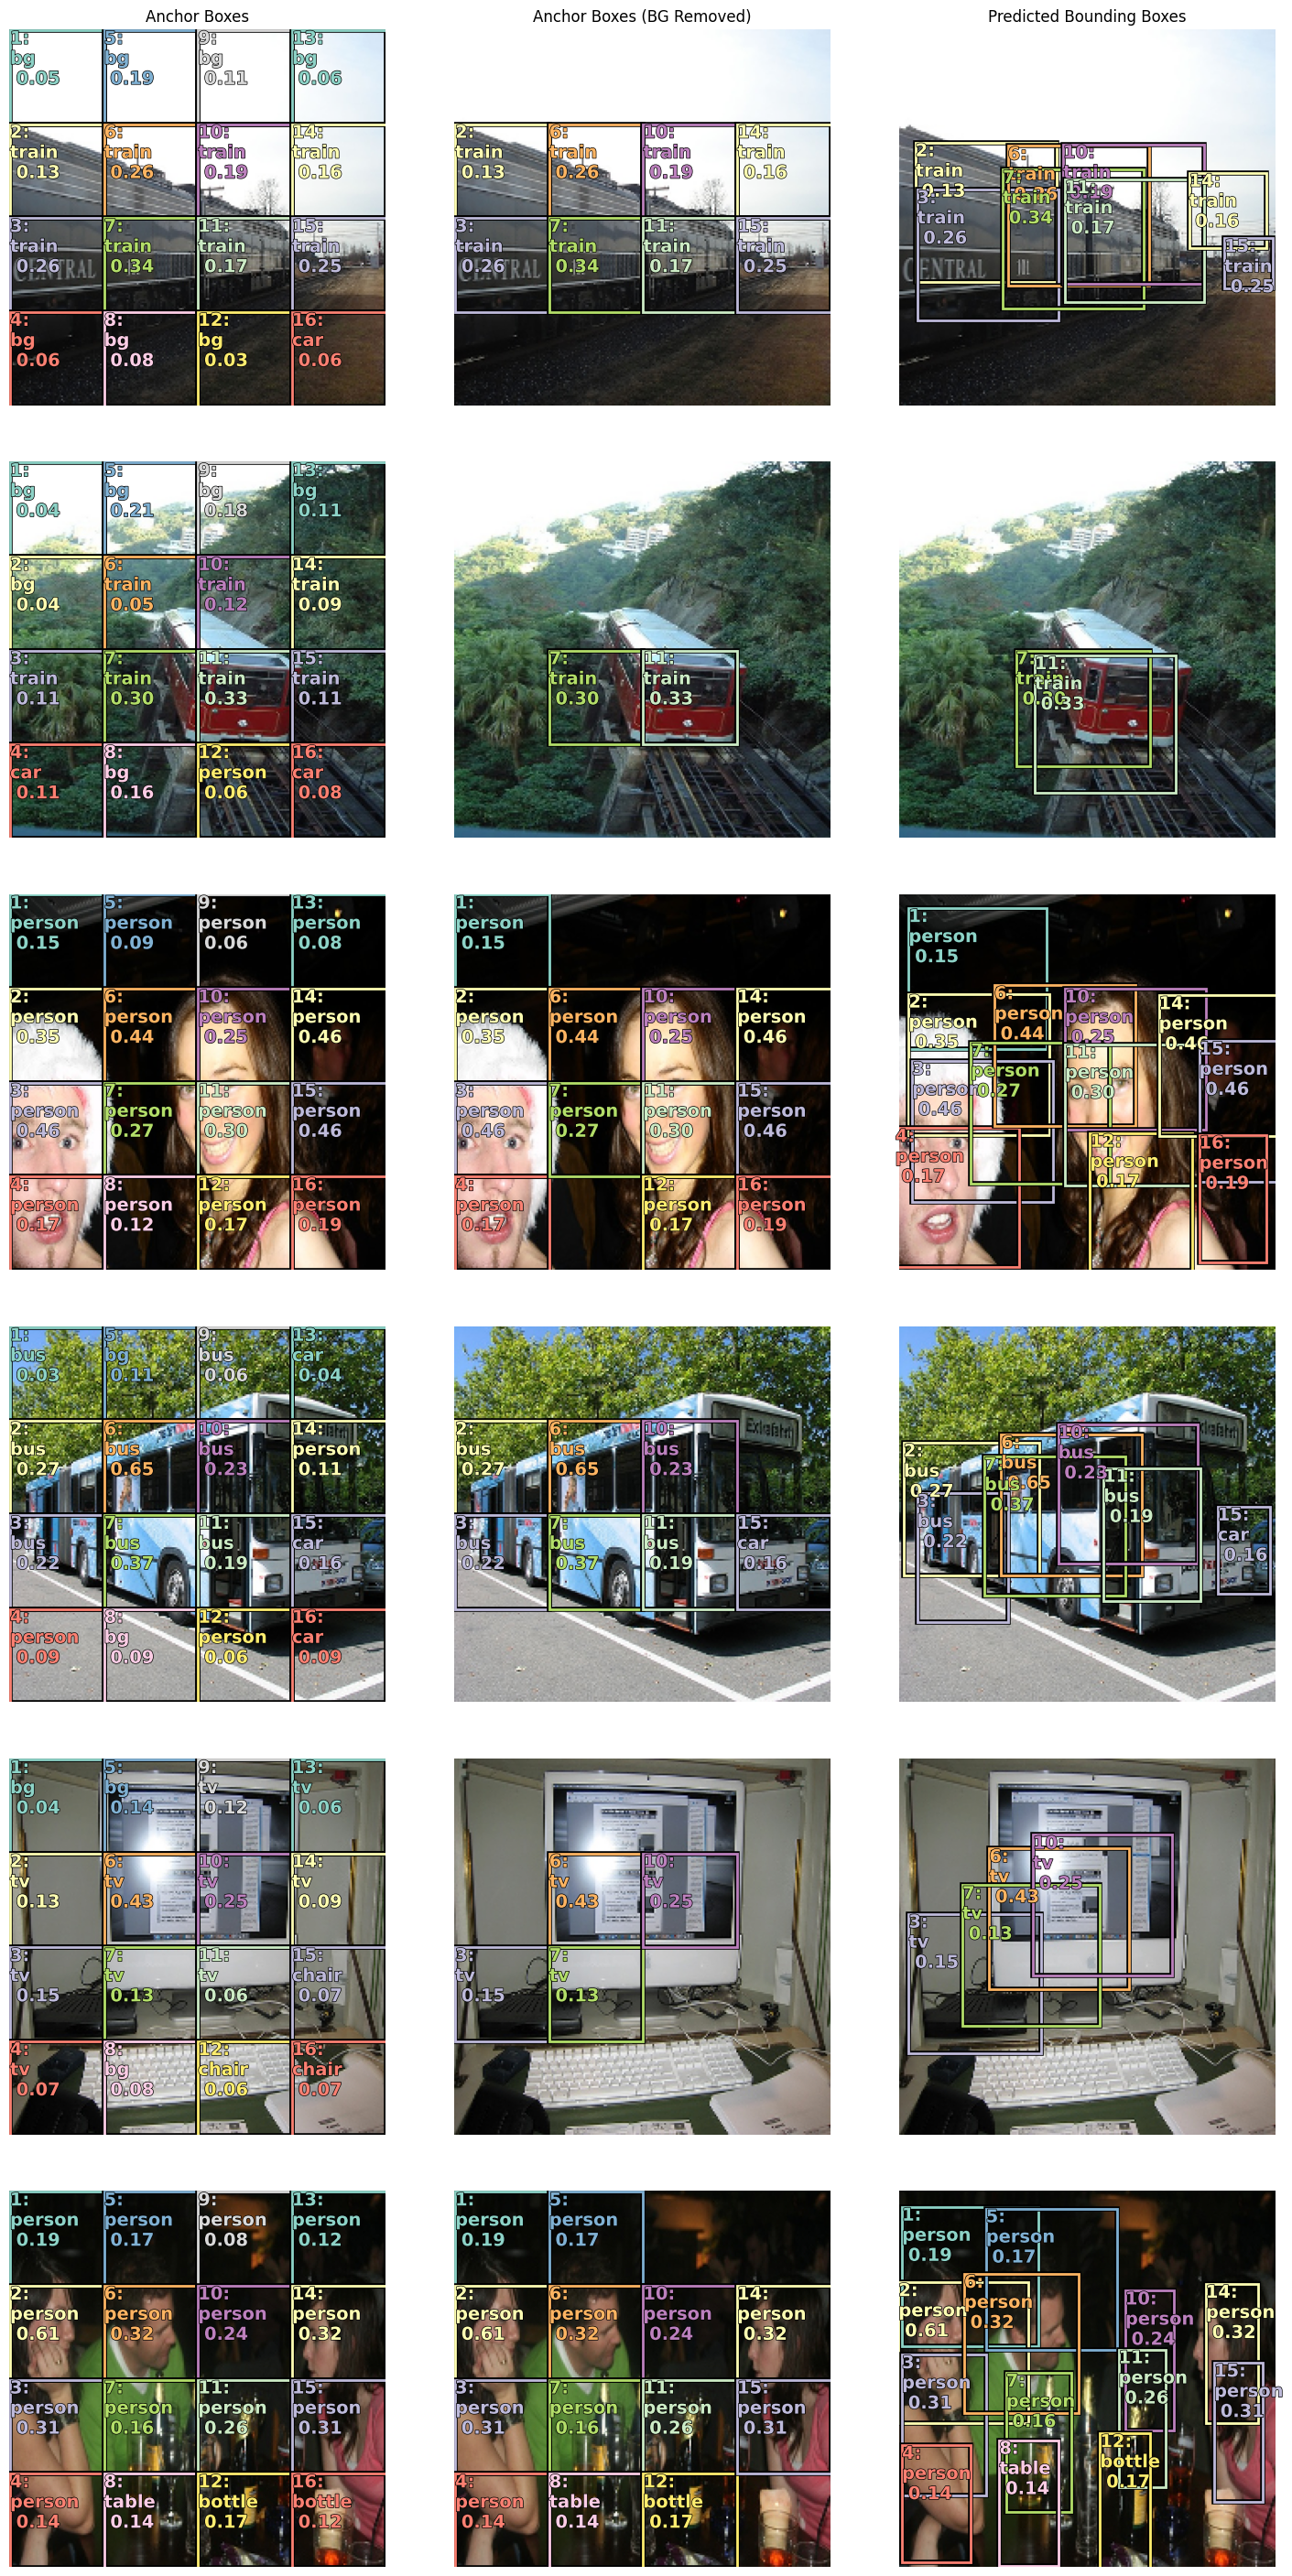

In [79]:
subset = [5,7,11,15,24,28]
x,targ_bbox,targ_clas = xb[subset],targ_bboxb[subset],targ_clasb[subset]  # just look at one image in the batch

# Run the batch (just the images) through our model and let it predict bounding boxes and classes
with torch.no_grad():
    pred_clas,pred_bbox = model(x.cuda()) # Get predictions (b_class: class probabilities, b_bb: bounding boxes)

show_preds(x,pred_clas,pred_bbox,thresh=0.13)

### Summary



I know that was alot to take in and trust me it was a lot to write out as well.  But we're about 90-95% of the way there.  I think there is about one more article in this series.  In the next article, we'll take a look at how to handle overlapping bounding boxes and how to scale up our multi-object detection even further and providing more flexibility for the model to detect objects at different scales and aspect ratios. 

If you're enjoying this series, please like and retweet my content on Twitter, [@johnrobinsn](https://twitter.com/johnrobinsn)